In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
masoudnickparvar_brain_tumor_mri_dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')
sartajbhuvaji_brain_tumor_classification_mri_path = kagglehub.dataset_download('sartajbhuvaji/brain-tumor-classification-mri')

print('Data source import complete.')


Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Using Colab cache for faster access to the 'brain-tumor-classification-mri' dataset.
Data source import complete.


In [ ]:
# --- Patch A: Build train/val/test splits (stratified) ---
import os
from sklearn.model_selection import train_test_split
import json

train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir  = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# gather all Training files
all_train_paths = []
all_train_labels = []
for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    if not os.path.isdir(label_path):
        continue
    for fname in os.listdir(label_path):
        all_train_paths.append(os.path.join(label_path, fname))
        all_train_labels.append(label)

# gather test files (final holdout)
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    label_path = os.path.join(test_dir, label)
    if not os.path.isdir(label_path):
        continue
    for fname in os.listdir(label_path):
        test_paths.append(os.path.join(label_path, fname))
        test_labels.append(label)

# deterministic label order and mapping
label_list = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
label_to_index = {lab: i for i, lab in enumerate(label_list)}

# save class order
with open("class_order.json", "w") as f:
    json.dump(label_list, f)
print("Class order saved:", label_list)

# stratified split: 80% train / 20% val
RANDOM_SEED = 42
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_train_paths, all_train_labels, test_size=0.2, random_state=RANDOM_SEED, stratify=all_train_labels
)

print(f"Counts -> train: {len(train_paths)}, val: {len(val_paths)}, test: {len(test_paths)}")


Class order saved: ['glioma', 'meningioma', 'notumor', 'pituitary']
Counts -> train: 4569, val: 1143, test: 1311


In [ ]:
# --- Patch B: Augmentation, open_images, encode_label, datagen ---
from PIL import Image, ImageEnhance
import numpy as np
import random
from tensorflow.keras.preprocessing.image import load_img

def augment_image_np(image_np):
    """Input: numpy uint8 0..255. Output: float32 0..1 augmented."""
    img = Image.fromarray(np.uint8(image_np))
    img = ImageEnhance.Brightness(img).enhance(random.uniform(0.8, 1.2))
    img = ImageEnhance.Contrast(img).enhance(random.uniform(0.8, 1.2))
    return np.array(img).astype(np.float32) / 255.0

def open_images(paths, augment=False):
    images = []
    for path in paths:
        img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img_np = np.array(img)  # 0..255
        if augment:
            img_np = augment_image_np(img_np)
        else:
            img_np = img_np.astype(np.float32) / 255.0
        images.append(img_np)
    return np.array(images, dtype=np.float32)

def encode_label(labels):
    # use deterministic mapping created in Patch A
    return np.array([label_to_index[l] for l in labels], dtype=np.int32)

def datagen(paths, labels, batch_size=12, augment=False, shuffle_data=True):
    """Infinite generator for Keras .fit with explicit steps_per_epoch."""
    n = len(paths)
    indices = np.arange(n)
    while True:
        if shuffle_data:
            np.random.shuffle(indices)
        for start in range(0, n, batch_size):
            batch_idx = indices[start:start+batch_size]
            batch_paths = [paths[i] for i in batch_idx]
            batch_labels = [labels[i] for i in batch_idx]
            batch_images = open_images(batch_paths, augment=augment)
            batch_labels_enc = encode_label(batch_labels)
            yield batch_images, batch_labels_enc


In [ ]:
# --- Correct Model Build Cell (Run AFTER Patch A + Patch B imports) ---

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

IMAGE_SIZE = 224

base_model = VGG16(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = True
for layer in base_model.layers[:-4]:   # freeze all except last 4 layers
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(label_list), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,068 (56.64 MB)

 Trainable params: 7,212,292 (27.51 MB)

 Non-trainable params: 7,635,776 (29.13 MB)

In [ ]:
# --- Patch C: Recompute steps and train using val_paths for validation ---
import math
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

batch_size = 32
train_steps = math.ceil(len(train_paths) / batch_size)
val_steps   = math.ceil(len(val_paths) / batch_size)
epochs = 25

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)

history = model.fit(
    datagen(train_paths, train_labels, batch_size=batch_size, augment=True, shuffle_data=True),
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_data=datagen(val_paths, val_labels, batch_size=batch_size, augment=False, shuffle_data=False),
    validation_steps=val_steps,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 506ms/step - accuracy: 0.5084 - loss: 1.2670 - val_accuracy: 0.8863 - val_loss: 0.4245 - learning_rate: 1.0000e-04
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 238ms/step - accuracy: 0.8357 - loss: 0.4673 - val_accuracy: 0.9134 - val_loss: 0.2577 - learning_rate: 1.0000e-04
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 230ms/step - accuracy: 0.9063 - loss: 0.2697 - val_accuracy: 0.8984 - val_loss: 0.3043 - learning_rate: 1.0000e-04
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 233ms/step - accuracy: 0.9197 - loss: 0.2342 - val_accuracy: 0.9358 - val_loss: 0.2051 - learning_rate: 1.0000e-04
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 233ms/step - accuracy: 0.9492 - loss: 0.1459 - val_accuracy: 0.9370 - val_loss: 0.2050 - learning_rate: 1.0000e-04
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 233ms/step - accuracy: 0.9606 - loss: 0.1157 - val_accuracy: 0.9510 - val_loss: 0.1723 - learning_rate: 1.0000e-04
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 28

In [ ]:
# --- Patch D: Batched test prediction (no augmentation) + metrics ---
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

def predict_in_batches(model, paths, batch_size=batch_size):
    probs = []
    for start in range(0, len(paths), batch_size):
        batch_paths = paths[start:start+batch_size]
        imgs = open_images(batch_paths, augment=False)
        p = model.predict(imgs)
        probs.append(p)
    return np.vstack(probs)

test_probs = predict_in_batches(model, test_paths, batch_size=batch_size)
test_labels_enc = encode_label(test_labels)
test_preds = np.argmax(test_probs, axis=1)

print("Classification Report (TEST):")
print(classification_report(test_labels_enc, test_preds, target_names=label_list))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

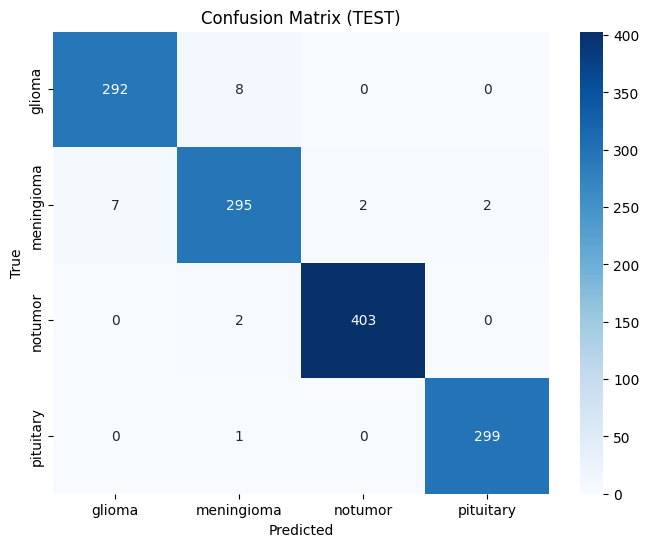

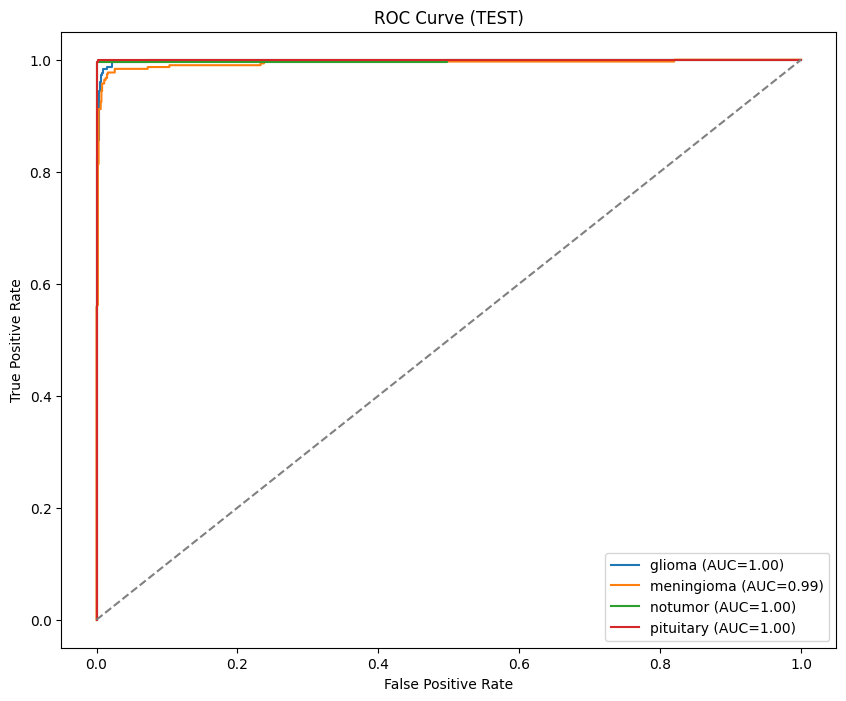

In [ ]:
# FIXED Patch D (Confusion Matrix + ROC)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Confusion Matrix
cm = confusion_matrix(test_labels_enc, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_list, yticklabels=label_list, cmap="Blues")
plt.title("Confusion Matrix (TEST)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC - AUC
test_labels_bin = label_binarize(test_labels_enc, classes=np.arange(len(label_list)))
fpr, tpr, roc_auc = {}, {}, {}

for i in range(len(label_list)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,8))
for i in range(len(label_list)):
    plt.plot(fpr[i], tpr[i], label=f"{label_list[i]} (AUC={roc_auc[i]:.2f})")

plt.plot([0,1],[0,1],'--', color='gray')
plt.title("ROC Curve (TEST)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Save test results to CSV
import pandas as pd
import numpy as np
from google.colab import files

# sanity checks
if 'test_paths' not in globals() or 'test_preds' not in globals():
    raise RuntimeError("Run Patch D first so test_paths/test_preds/test_probs/test_labels_enc exist.")

# Get confidences
if 'test_probs' in globals():
    confidences = np.max(test_probs, axis=1)
else:
    confidences = np.ones(len(test_preds))

# class names
if 'label_list' in globals():
    names = label_list
elif 'class_order' in globals():
    names = class_order
else:
    raise RuntimeError("No label list found (label_list or class_order).")

# Build dataframe
df = pd.DataFrame({
    'path': test_paths,
    'true_idx': test_labels_enc,
    'pred_idx': test_preds,
    'confidence': confidences
})
df['true_label'] = df['true_idx'].apply(lambda i: names[int(i)])
df['pred_label'] = df['pred_idx'].apply(lambda i: names[int(i)])
df['correct'] = df['true_idx'] == df['pred_idx']

# Save and download
csv_out = "test_results.csv"
df.to_csv(csv_out, index=False)
print("Saved:", csv_out, "rows:", len(df))
files.download(csv_out)   # will prompt browser to download


Saved: test_results.csv rows: 1311


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Copy misclassified examples to folder
import os, shutil

out_folder = "/content/misclassified_examples"
os.makedirs(out_folder, exist_ok=True)

mis_df = df[~df['correct']].sort_values(by='confidence', ascending=True)
print("Misclassified count:", len(mis_df))

for i, row in mis_df.iterrows():
    src = row['path']
    base = os.path.basename(src)
    # prefix with index,true,pred,conf for clarity
    safe_name = f"{i:04d}_T-{row['true_label']}_P-{row['pred_label']}_C-{row['confidence']:.2f}_{base}"
    dst = os.path.join(out_folder, safe_name)
    try:
        shutil.copy(src, dst)
    except Exception as e:
        print("Failed to copy", src, ":", e)

print("Copied misclassified images to:", out_folder)

# Optional: copy to Drive (if mounted)
drive_dst = "/content/drive/MyDrive/brain_tumor_models/misclassified_examples"
try:
    if os.path.exists('/content/drive'):
        os.makedirs(drive_dst, exist_ok=True)
        for f in os.listdir(out_folder):
            shutil.copy(os.path.join(out_folder, f), os.path.join(drive_dst, f))
        print("Also copied to Drive:", drive_dst)
except Exception as e:
    print("Drive copy skipped or failed:", e)


Misclassified count: 22
Copied misclassified images to: /content/misclassified_examples
Also copied to Drive: /content/drive/MyDrive/brain_tumor_models/misclassified_examples


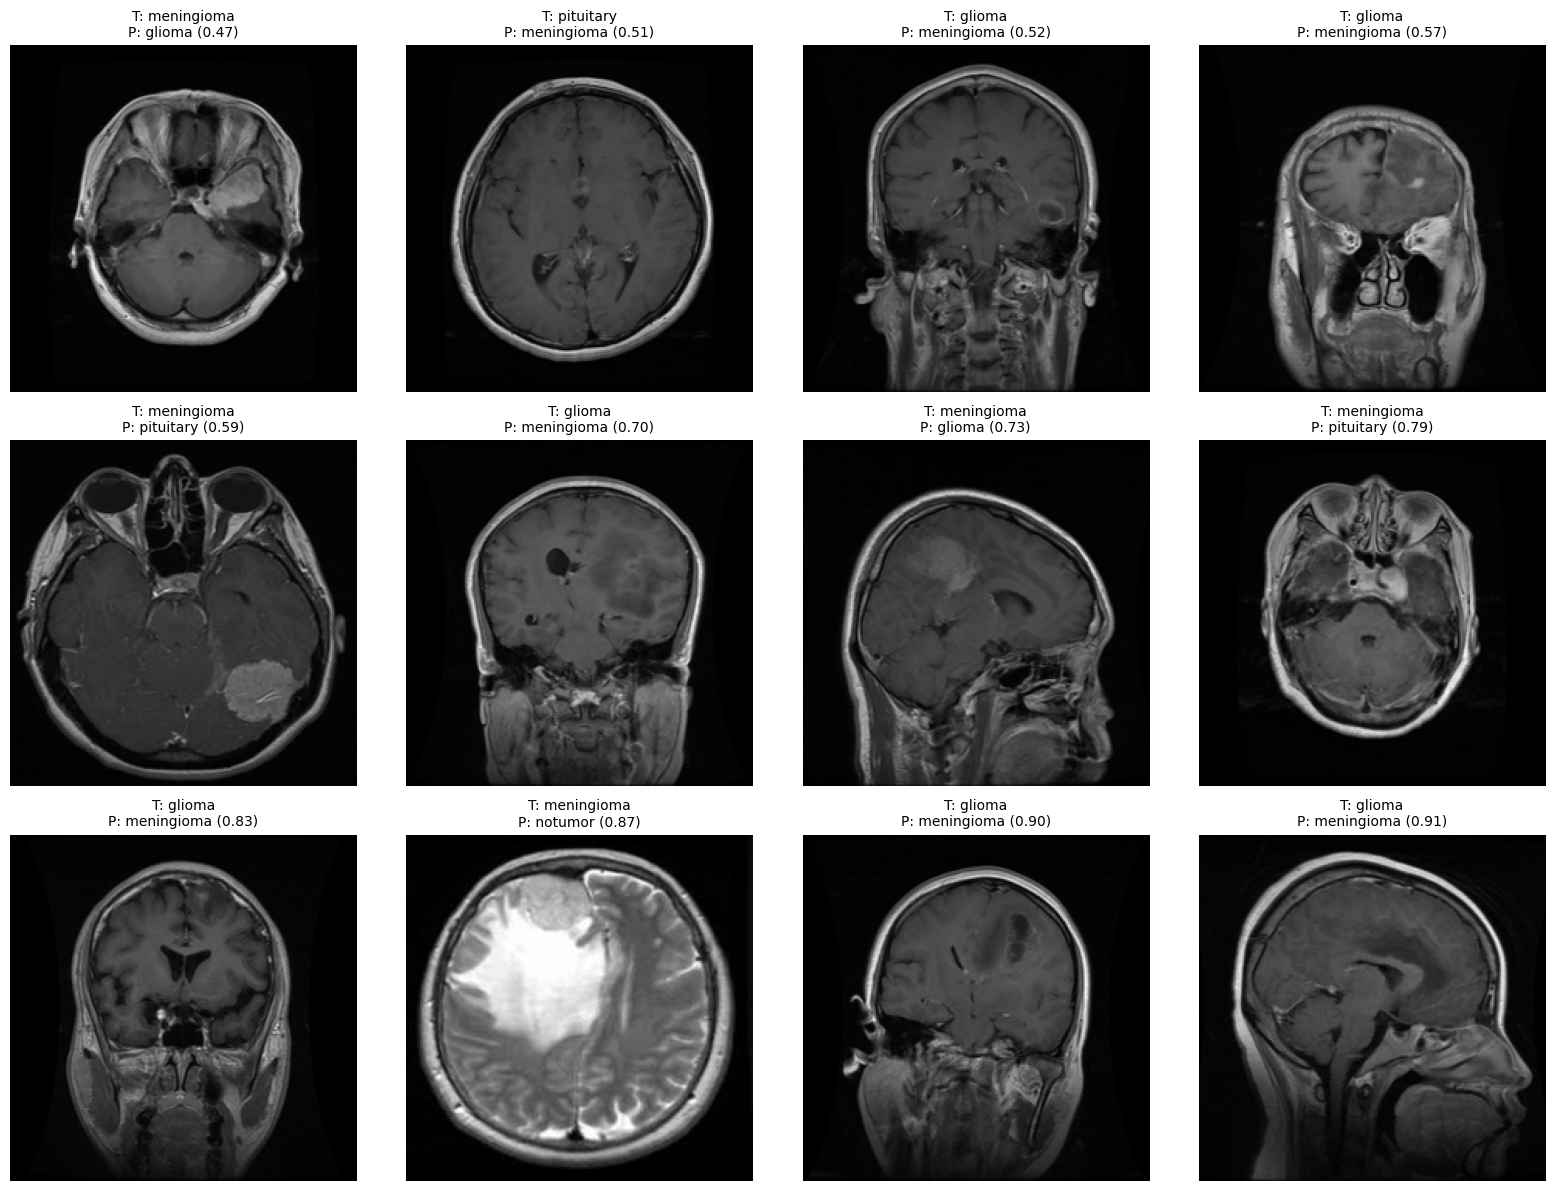

In [ ]:
# Display top-N misclassified images inline
from PIL import Image
import matplotlib.pyplot as plt
import math

N = 12   # change to show more/less
if len(mis_df) == 0:
    print("No misclassified images found.")
else:
    display_df = mis_df.head(N)
    cols = 4
    rows = math.ceil(len(display_df) / cols)
    plt.figure(figsize=(cols*4, rows*4))
    for idx, (_, row) in enumerate(display_df.iterrows()):
        img = Image.open(row['path']).convert('RGB').resize((224,224))
        plt.subplot(rows, cols, idx+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"T: {row['true_label']}\nP: {row['pred_label']} ({row['confidence']:.2f})", fontsize=10)
    plt.tight_layout()
    plt.show()


In [ ]:
# --- Patch 1: Mount Drive and save model + weights + class_order.json ---
from google.colab import drive
import os
import json

# Mount drive (will prompt you to authorize)
drive.mount('/content/drive', force_remount=False)

# Make folder in your Drive
drive_folder = '/content/drive/MyDrive/brain_tumor_models'
os.makedirs(drive_folder, exist_ok=True)

# Save full model (Keras .keras) and weights-only (.weights.h5)
full_model_path = os.path.join(drive_folder, 'final3.keras')
weights_path    = os.path.join(drive_folder, 'final_weights.weights.h5')
class_order_dst = os.path.join(drive_folder, 'class_order.json')

# Save full model
model.save(full_model_path, include_optimizer=False)   # saves architecture + weights
print("Saved full model ->", full_model_path)

# Save weights only (useful for re-loading into same architecture)
model.save_weights(weights_path)
print("Saved weights ->", weights_path)

# Copy class_order.json (if it's in working dir)
if os.path.exists('class_order.json'):
    import shutil
    shutil.copy('class_order.json', class_order_dst)
    print("Copied class_order.json ->", class_order_dst)
else:
    # If not found, write it from label_list variable (if available)
    try:
        with open(class_order_dst, 'w') as f:
            json.dump(label_list, f)
        print("Created class_order.json from label_list ->", class_order_dst)
    except Exception as e:
        print("class_order.json not found and label_list not available:", e)

# List saved files
print("\nFiles in drive folder:")
print(os.listdir(drive_folder))


Mounted at /content/drive
Saved full model -> /content/drive/MyDrive/brain_tumor_models/final3.keras
Saved weights -> /content/drive/MyDrive/brain_tumor_models/final_weights.weights.h5
Copied class_order.json -> /content/drive/MyDrive/brain_tumor_models/class_order.json

Files in drive folder:
['final3.keras', 'final_weights.weights.h5', 'class_order.json']


In [ ]:
# --- Patch 2: Download saved files to local PC from Colab ---
from google.colab import files
import os

drive_folder = '/content/drive/MyDrive/brain_tumor_models'
files_to_download = [
    os.path.join(drive_folder, 'final3.keras'),
    os.path.join(drive_folder, 'final_weights.weights.h5'),
    os.path.join(drive_folder, 'class_order.json'),
]

for p in files_to_download:
    if os.path.exists(p):
        print("Downloading:", p)
        files.download(p)
    else:
        print("Not found (skipping):", p)

# NOTE: If a file is very large (hundreds of MB), browser download may be slow or fail.
# If that happens, download directly from Google Drive web UI (open Drive -> My Drive -> brain_tumor_models).


Downloading: /content/drive/MyDrive/brain_tumor_models/final3.keras


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: /content/drive/MyDrive/brain_tumor_models/final_weights.weights.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: /content/drive/MyDrive/brain_tumor_models/class_order.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ============================
# PRINT CLASS ORDER + WEIGHTS
# ============================

import json
import numpy as np

# 1) ---- PRINT CLASS ORDER ----
print("=== CLASS ORDER ===")

try:
    with open("class_order.json", "r") as f:
        class_order = json.load(f)
    print("Class order found in class_order.json:")
    for i, cls in enumerate(class_order):
        print(f"{i}: {cls}")
except Exception as e:
    print("Could not read class_order.json:", e)
    try:
        print("Using label_list variable instead:")
        print(label_list)
    except:
        print("No class order available!")


# 2) ---- PRINT MODEL LAYERS + WEIGHT SHAPES ----
print("\n=== MODEL WEIGHT SHAPES ===")
print("(Layer index : Layer name -> number of arrays : shapes)\n")

for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    shapes = [w.shape for w in weights]
    print(f"{i:02d}: {layer.name:30s} -> {len(shapes)} arrays; shapes: {shapes}")


# 3) ---- (OPTIONAL) PRINT WEIGHTS OF A SPECIFIC LAYER ----
# Set this to the layer you want to inspect. Example: 'dense', 'batch_normalization', 'dropout', etc.
layer_name_to_view = None   # put layer name as string, e.g. "dense"

if layer_name_to_view:
    try:
        layer = model.get_layer(name=layer_name_to_view)
        w = layer.get_weights()
        print(f"\n=== WEIGHTS FROM LAYER: {layer_name_to_view} ===")
        for idx, arr in enumerate(w):
            print(f"Array {idx} shape: {arr.shape}")
            print(arr)   # comment this out if too large
    except:
        print(f"Layer '{layer_name_to_view}' not found.")


=== CLASS ORDER ===
Class order found in class_order.json:
0: glioma
1: meningioma
2: notumor
3: pituitary

=== MODEL WEIGHT SHAPES ===
(Layer index : Layer name -> number of arrays : shapes)

00: vgg16                          -> 26 arrays; shapes: [(3, 3, 3, 64), (64,), (3, 3, 64, 64), (64,), (3, 3, 64, 128), (128,), (3, 3, 128, 128), (128,), (3, 3, 128, 256), (256,), (3, 3, 256, 256), (256,), (3, 3, 256, 256), (256,), (3, 3, 256, 512), (512,), (3, 3, 512, 512), (512,), (3, 3, 512, 512), (512,), (3, 3, 512, 512), (512,), (3, 3, 512, 512), (512,), (3, 3, 512, 512), (512,)]
01: global_average_pooling2d       -> 0 arrays; shapes: []
02: dropout                        -> 0 arrays; shapes: []
03: dense                          -> 2 arrays; shapes: [(512, 256), (256,)]
04: batch_normalization            -> 4 arrays; shapes: [(256,), (256,), (256,), (256,)]
05: dropout_1                      -> 0 arrays; shapes: []
06: dense_1                        -> 2 arrays; shapes: [(256, 4), (4,)]


In [ ]:
# Run this in Colab where the model was trained (or where it loads correctly)
import tensorflow as tf
from tensorflow.keras.models import load_model

# If you can load the old file here (in Colab) do it, otherwise use the model object in memory:
# old = load_model("final3.keras", compile=False, safe_mode=False)  # if this works here
old = model   # use the working model object you already have

# Build a clean functional Model from inputs -> outputs
inp  = old.inputs[0]     # main input tensor
outp = old.outputs[0]    # final output tensor
clean = tf.keras.Model(inputs=inp, outputs=outp, name="brain_tumor_clean")

# Save the cleaned model (Keras .keras format)
clean.save("final_clean.keras", include_optimizer=False)
print("Saved clean model -> final_clean.keras")
# Optionally also save weights-only (compatible across TF versions usually)
clean.save_weights("final_clean.weights.h5")
print("Saved weights -> final_clean.weights.h5")


Saved clean model -> final_clean.keras
Saved weights -> final_clean.weights.h5


In [ ]:
from google.colab import files
files.download("final_clean.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>